In [1]:
from operator import add, truediv
from numba import njit,vectorize, prange, errors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [92]:
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import itertools
import warnings
import random
import sys
import os

In [4]:
warnings.simplefilter('ignore', category=errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=errors.NumbaPendingDeprecationWarning)

In [5]:
sbn.set()

# 1. Un proceso en redes. 

En un notebook pasado ya aboradamos el algortimo de Gillespie con poblaciones abiertas y cerradas pero la geometría del problema no era explícita. En esta vez vamos a inducir una geometría discreta muy similar a _parches_ donde éstos van a tener poblaciones de especies químicas que se relacionarán y podrán interactuar no solamente de manera local sino también de manera global. 

## 1.1 Una reacción sencilla

Vamos a comenzar con un proiceso en una malla simétrica con condiciones periódicas a la frontera. Va a analizar primero a siguiente reacción
$$
S_{i} \xrightarrow{\;\; c \;\; } \emptyset
$$
Donde $S_{i}$ es la población de especie $S$ en el nodo $i$. Para esta primera parte vamos a asumir que no hay un proceso de difusión (los nodos están aislados).

Vamos a comenzar una malla de $3\times 3$, inicializaremos un número entero aleatorio para cada punto de la malla.

In [72]:
M = np.random.randint(low=0,high = 1000,size=(3,3))

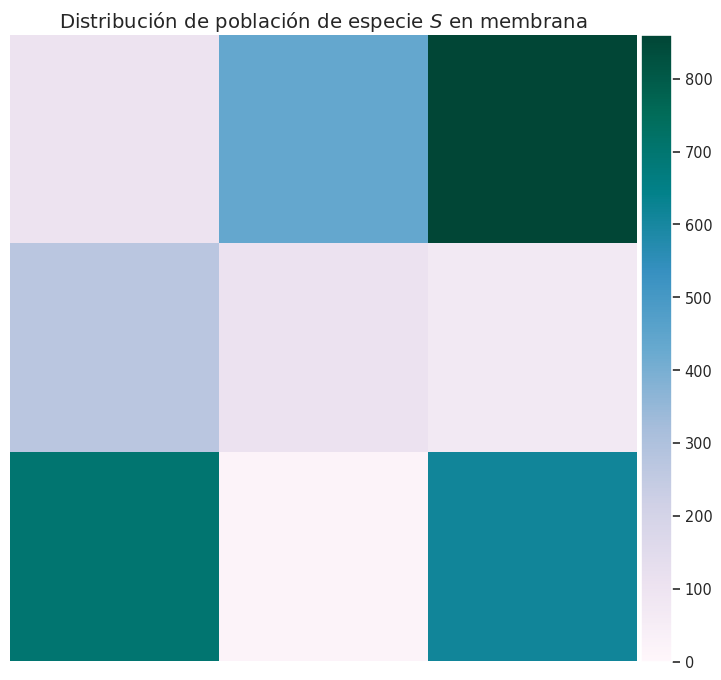

In [73]:
fig,ax = plt.subplots(1,1,dpi=95,figsize=(9,9))

im = ax.imshow(M,
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax.set_title(r'Distribución de población de especie $S$ en membrana',
             fontdict={'fontsize':15,})
ax.set_axis_off()

plt.show()

Ahora, vamos a realizar la simulación para la evolución de la población global en la membrana en función de cada uno de los patches siguiento el algoritmo de Gillespie. 
Como solamente tenemos una función el vector de cambio será $\nu = -1$ y la probabilidad de una reacción a ocurrir en cada uno de los pathches será proporcional a la abundacia molecular de especies en ese parche.

In [74]:
@njit
def random_exp_numpy(a0):
    """
    This functions generates a exponential random 
    variable with mean and std. dev. 1/a0
    """
    r = np.random.random()
    return (1/a0)*np.log(1/r)

@njit
def sum_vectors_list(a,b):
    l = []
    n = len(a)
    for i in prange(n):
        l.append(a[i]+b[i])
    return l

@njit
def sum_vect(a):
    n = len(a)
    k = 0.0
    for i in prange(n):
        k += a[i]
    return k

@njit
def div_vect(a,a0):
    n = len(a)
    b = []
    for i in prange(n):
        b.append(a[i]/a0)
    return b

In [75]:
_=random_exp_numpy(2)
_=sum_vectors_list([1,2],[1,2])
_=sum_vect([1,2])
_=div_vect([1,2],1)

In [76]:
def SSA(M,t_max=1):
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    
    sp = M.shape[0] #define dimension
    n = sp**2
    patch_idx_2d = list(itertools.product(range(sp),range(sp)))
    patch_idx = list(range(sp**2))
    while t0<=t_max:
        
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        
        #selct patch
        m_sum = np.sum(Mt)
        j = random.choices(patch_idx, weights=map(truediv,M.reshape(M.shape[0]**2),[m_sum]*n))[0]
        #print(j)
        #print(patch_idx_2d[j])
        #break
        Mt[patch_idx_2d[j][0],patch_idx_2d[j][1]] += -1
        tau = random_exp_numpy(m_sum)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [77]:
evolM,T = SSA(M,t_max=5)

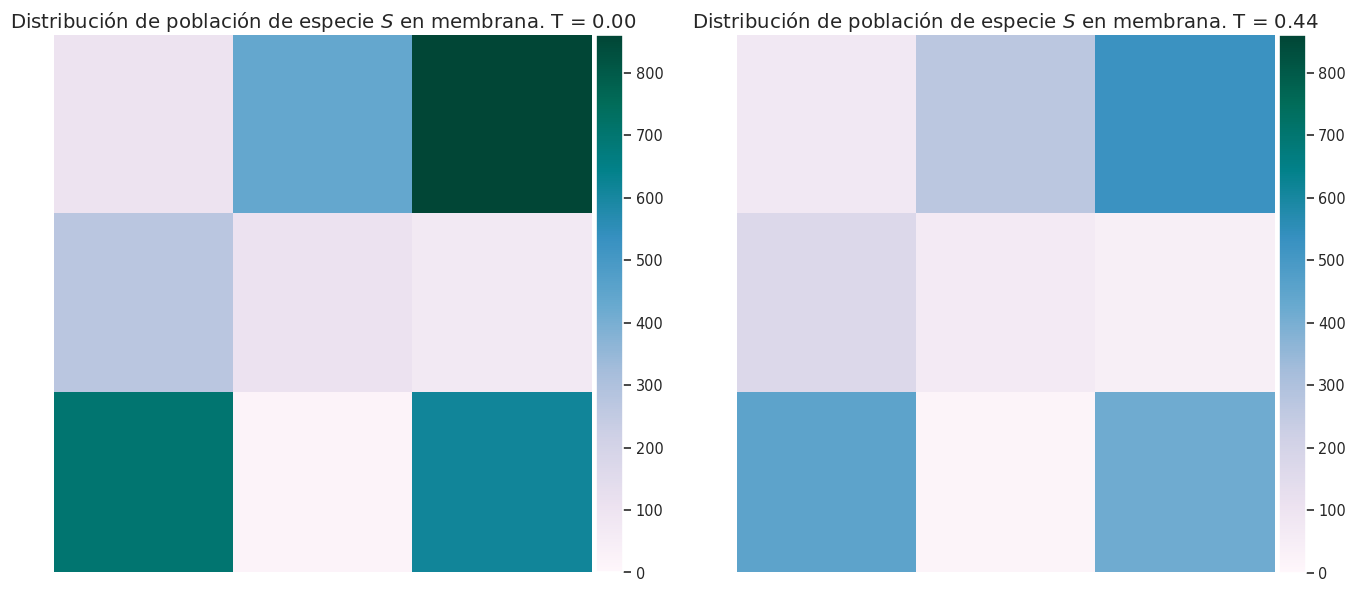

In [78]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

im = ax[0].imshow(M,
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[0]),
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(evolM[-2000],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[-2000]),
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

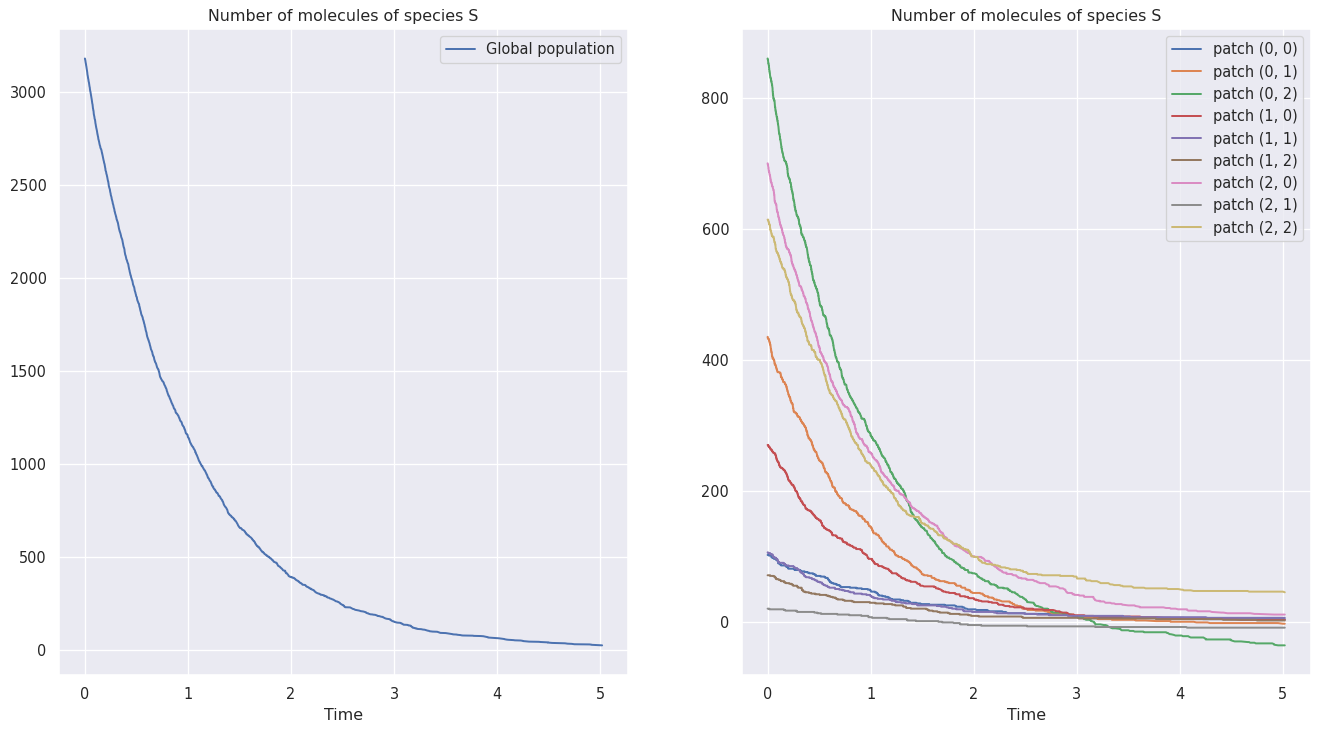

In [79]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

ax[0].plot(T,[np.sum(m) for m in evolM],label='Global population')
ax[0].set_title('Evolución de la población global de la espcie S',)
ax[0].set_xlabel('Time')
ax[0].set_title('Number of molecules of species S')
ax[0].legend()

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[1].plot(T,[m[patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch))

ax[1].set_xlabel('Time')
ax[1].set_title('Number of molecules of species S')
ax[1].legend()

plt.show()

Una cosa bien importante de notar que es podemos ver que en algunas partes la población de moleculas se hace cero mismo que no tiene sentido. Por ello vamos a poner una constricción del tipo $a_{+}$ donde $a_{+} = a \; if\; a\ge0 \;otherwise\; 0 $

In [80]:
@njit
def a_positive(a):
    if a>=0:
        return a
    else:
        return 0

In [81]:
_ = a_positive(3)

In [82]:
def SSA(M,t_max=1):
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    
    sp = M.shape[0] #define dimension
    n = sp**2
    patch_idx_2d = list(itertools.product(range(sp),range(sp)))
    patch_idx = list(range(sp**2))
    while t0<=t_max:
        
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        
        #selct patch
        m_sum = np.sum(Mt)
        j = random.choices(patch_idx, weights=map(truediv,M.reshape(M.shape[0]**2),[m_sum]*n))[0]
        #print(j)
        #print(patch_idx_2d[j])
        #break
        Mt[patch_idx_2d[j][0],patch_idx_2d[j][1]] = a_positive(Mt[patch_idx_2d[j][0],patch_idx_2d[j][1]]-1)
        tau = random_exp_numpy(m_sum)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [83]:
evolM,T = SSA(M,t_max=5)

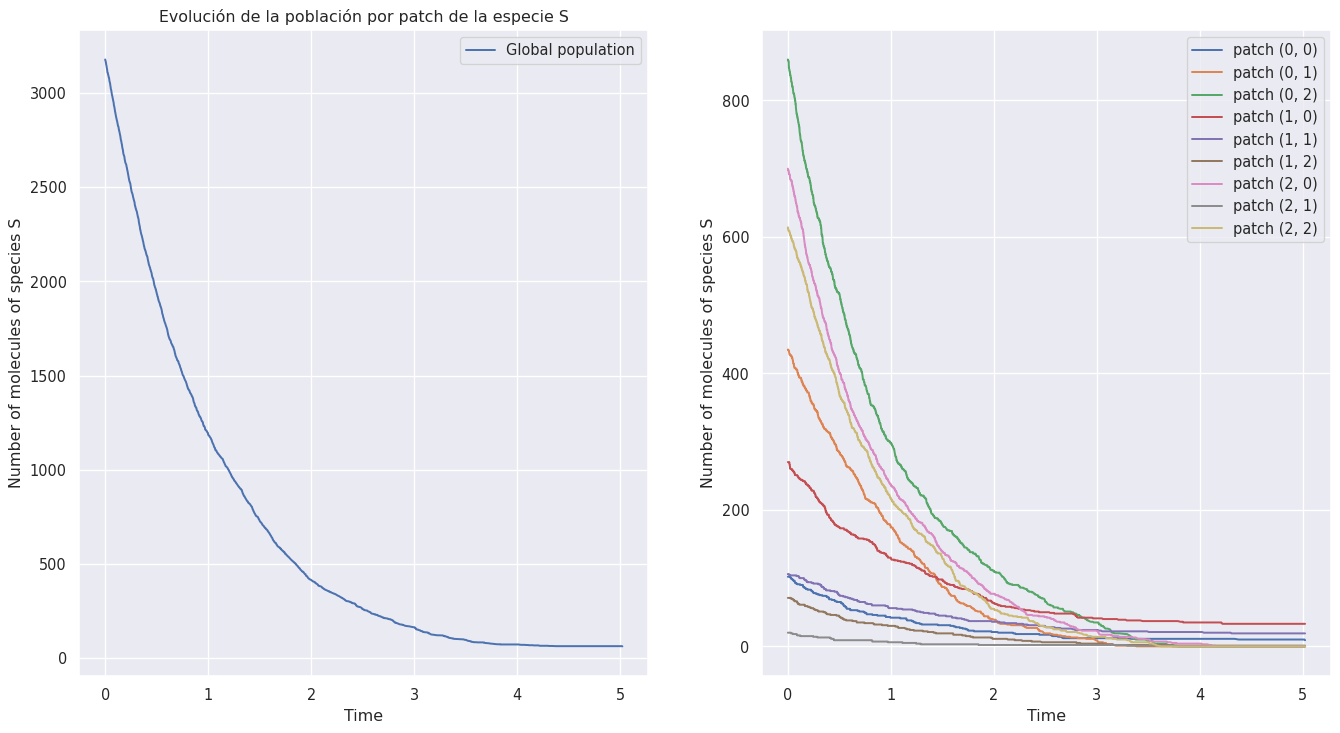

In [84]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

ax[0].plot(T,[np.sum(m) for m in evolM],label='Global population')
ax[0].set_title('Evolución de la población global de la espcie S',)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of molecules of species S')
ax[0].legend()

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[1].plot(T,[m[patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch))

ax[0].set_title('Evolución de la población por patch de la especie S',)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Number of molecules of species S')
ax[1].legend()

plt.show()

Ahora que el problema está corregido vamos a comenzar a agregar la difusión, esto es considerar el set de reacciones:
$$
\begin{eqnarray}
S_{i} \xrightarrow{\;\; c_{1} \;\; } \emptyset \\
S_{i} \xrightarrow{\;\; c_{2} \;\; } S_{j}
\end{eqnarray}
$$

Aquí o bien se mueve una molécula del patch $i$ al $j$ (proceso difusivo) o bien se convierte decae a la especie $\emptyset$

In [85]:
def reactions(Y,c1=1,c2=0.4):
    return [Y*c1,Y*c2]

In [86]:
def SSA_diff(M,a,v,t_max=1,seed=42):
    
    np.random.seed(seed=42)
    
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    
    sp = M.shape[0] #define dimension
    n = sp**2 # Define flaten dimension
    patch_idx_2d = list(itertools.product(range(sp),range(sp))) #define all the combinations of matrix entries
    patch_idx = list(range(sp**2)) #The idx of patch_idx_2d combinations
    neighb_patch = list(filter(lambda x: abs(x[0])!=abs(x[1]),itertools.product(range(-1,2),range(-1,2)))) # The valid neighbors
    idx = list(range(len(v)))
    while t0<=t_max:
        
        #select population
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        m_sum = np.sum(Mt)
        
        #select reaction
        a_vector = a(m_sum)
        a_0 = np.sum(a_vector)
        j = random.choices(idx,weights=a_vector/a_0)[0]
        
        
        #selct patch
        J = random.choices(patch_idx, weights=map(truediv,M.reshape(M.shape[0]**2),[m_sum]*n))[0]
        
        if j == 0:
            Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]] = a_positive(Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]]-1)
        else:
            if a_positive(Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]]-1) > 0:
                dummy = random.choices(neighb_patch,k=1)[0]
                Mt[(patch_idx_2d[J][0]+dummy[0])%sp ,(patch_idx_2d[J][1]+dummy[1])%sp ] += 1
                Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]] += -1
                #print('{}->{},{}'.format(patch_idx_2d[J],[(patch_idx_2d[J][0]+dummy[0])%sp ,(patch_idx_2d[J][1]+dummy[1])%sp],dummy))
            
        tau = random_exp_numpy(m_sum)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [87]:
evolM_p,T_p = SSA_diff(M,a=reactions,v=[-1,-1],t_max=5,seed=3)

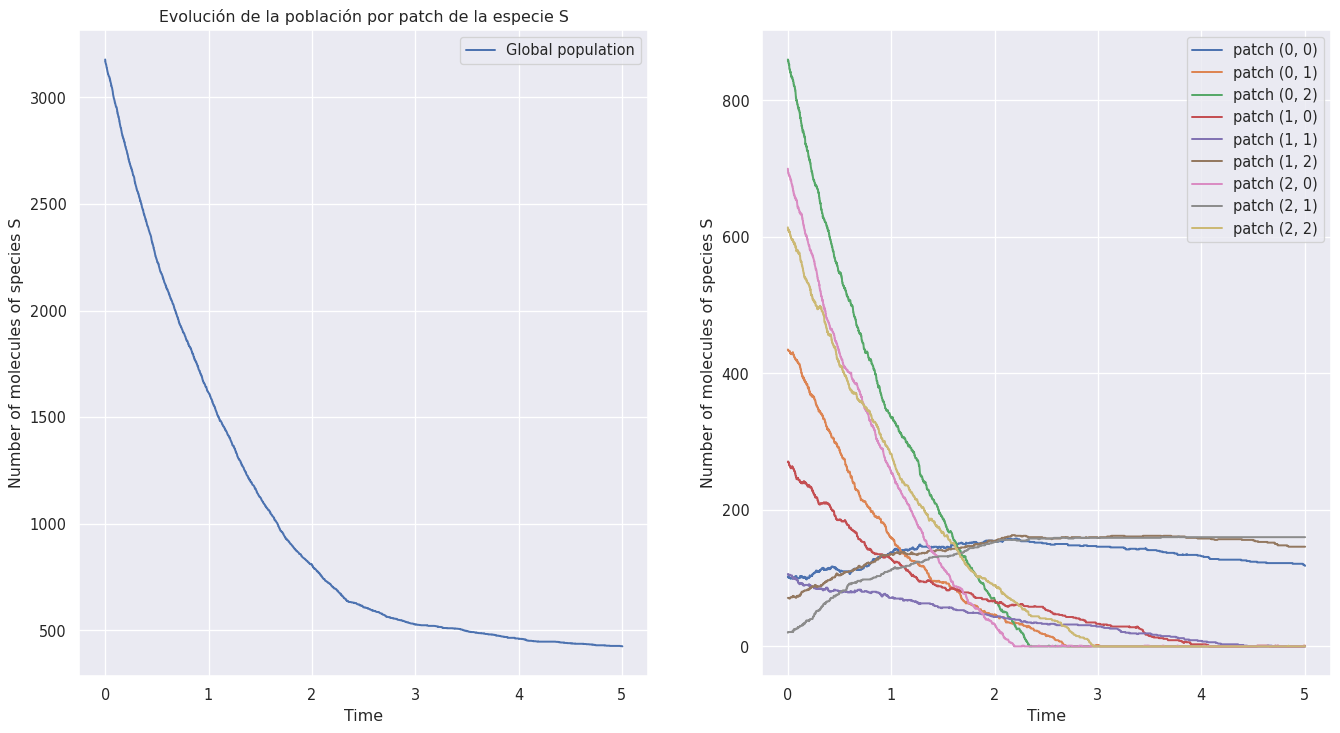

In [88]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

ax[0].plot(T_p,[np.sum(m) for m in evolM_p],label='Global population')
ax[0].set_title('Evolución de la población global de la espcie S',)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of molecules of species S')
ax[0].legend()

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[1].plot(T_p,[m[patch[0],patch[1]] for m in evolM_p], label='patch {}'.format(patch))

ax[0].set_title('Evolución de la población por patch de la especie S',)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Number of molecules of species S')
ax[1].legend()

plt.show()

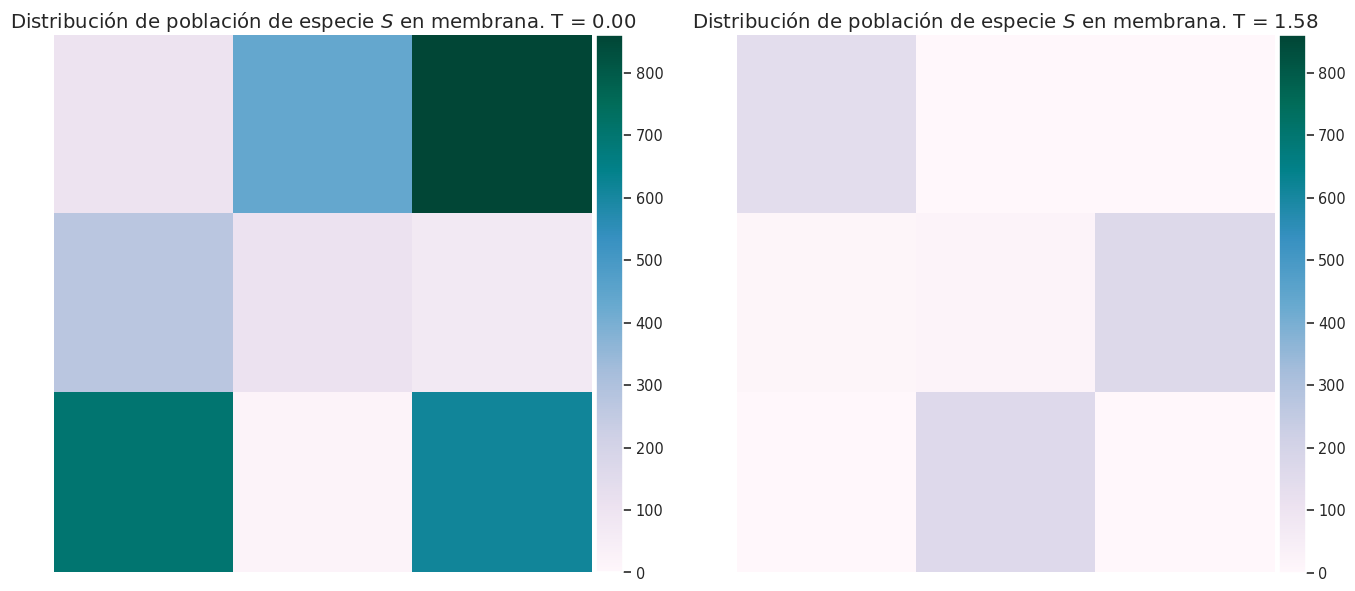

In [89]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

im = ax[0].imshow(M,
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[0]),
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(evolM_p[-700],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[-700]),
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

In [164]:
fig, ax = plt.subplots(1,1,figsize=(9,8),dpi=93)
img = []
ax.set_axis_off()
im = ax.imshow(evolM[0],cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax.set_title('Decay without diffusion')
for t,m in zip(T[1::30],evolM[1::30]):
    title = ax.text(0.5,1.05,"T = {:.2f}".format(t), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    img.append([ax.imshow(m,
                          cmap='PuBuGn',
                          vmin=0,
                          vmax=np.max(M),),title])
    
plt.close()

In [165]:
anim = animation.ArtistAnimation(fig, img, interval=80, blit=True,repeat_delay=0)
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='jshtml')
rc

HTML(anim.to_jshtml())

In [166]:
fig, ax = plt.subplots(1,1,figsize=(9,8),dpi=93)
img = []
ax.set_axis_off()
im = ax.imshow(evolM[0],cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax.set_title('Decay with diffusion')
for t,m in zip(T_p[1::30],evolM_p[1::30]):
    title = ax.text(0.5,1.05,"T = {:.2f}".format(t), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    img.append([ax.imshow(m,
                          cmap='PuBuGn',
                          vmin=0,
                          vmax=np.max(M),),title])
    
plt.close()

In [167]:
anim = animation.ArtistAnimation(fig, img, interval=80, blit=True,repeat_delay=0)
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='jshtml')
rc

HTML(anim.to_jshtml())